<a href="https://colab.research.google.com/github/JoaoAlexandreFerreira/PINNs/blob/main/Rede_neural_para_o_CILAMCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Código com o objetivo de montar uma Rede Neural Artificial para formar um poliômio que relacione a densidade em função da pressão.

A arquitetura inicial é a seguinte:


*   Duas entradas: Pressão e Salinidade;
*   Uma saída: Densidade.

Será realizado estudo da rede "perfeita", i.e., a rede com o menor erro relativo em função do número de camadas ocultas, número de neurônios ocultos, função de ativação e taxa de aprendizado.

A saber, as funções de ativação testadas serão:


1.   Sigmóide;
2.   Tangente Hipérbolica;
3.   Relu;
4.   LeakyRelu;

Com as seguintes taxas de aprendizado:



1.   0.01
2.   0.005
3.  0.001

Importando as bibliotecas necessárias

In [1]:
from keras.models import Sequential
from keras.layers import Dense
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import  MeanRelativeError
from sklearn.metrics import mean_absolute_error
from keras.initializers import Ones, GlorotNormal, he_normal, Zeros, Constant

tf.random.set_seed(231)

Definindo as funções e as taxas

In [2]:
funcoes = ['tanh', 'relu', 'sigmoid', 'LeakyReLU']
taxas = [0.005, 0.01, 0.05]

Função para definir o modelo e o treino do mesmo

In [3]:
def modelo_RNA(x, activation, nos, camadas_ocultas):
  modelo = Sequential()
  modelo.add(tf.keras.layers.Input(shape=(x.shape[1],)))
  #modelo.add(keras.layers.Dense(nos, activation='relu', input_shape=x.shape))
  for i in range(camadas_ocultas):
    modelo.add(keras.layers.Dense(nos, activation=activation, kernel_initializer=GlorotNormal()))
  modelo.add(keras.layers.Dense(1, activation= 'linear'))
  modelo.summary()

  return modelo

def padronizar_peso(modelo):
  for layer in modelo.layers:
    if isinstance(layer, Dense):
      weights, biases = layer.get_weights()
      weights_mean = weights.mean()
      weights_std = weights.std()
      weights = (weights - weights_mean) / weights_std
      layer.set_weights([weights, biases])
    return modelo

def treino_modelo(modelo, optimizer, loss, metrics, x_treino, y_treino, x_teste, y_teste, itr):
  modelo.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  resultado = modelo.fit(x_treino, y_treino, epochs=itr, batch_size=5, verbose = 1, validation_data=(x_teste, y_teste))

  return resultado, modelo

def erro_relativo(y_pred, y_true):
  return np.mean(np.abs((y_true - y_pred) / y_true))

In [4]:
def custo_final(resultado):
    train_loss = resultado.history['loss']
    val_loss = resultado.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'custo treino': train_loss[idx_min_val_loss], 'custo validação': val_loss[idx_min_val_loss]}

def plot_erro(resultado):
    treino_loss = resultado.history['loss']
    val_loss = resultado.history['val_loss']

    fig, ax = plt.subplots()
    ax.semilogy(treino_loss, label='Treino')
    ax.semilogy(val_loss, label='Validação')
    ax.set(title='Curvas de erro para o treino e a validação', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

Extraindo o dataset necessário

In [5]:
df = pd.read_csv('data_cov (1).csv')
#y = df['Densidade']
#x = df.drop('Demsodade', axis = 1)

#proporção de treino e validação
prop_treino = 0.8 #80% treino e 20% validação

indices = np.arange(len(df))
treino, val = train_test_split(indices, train_size = prop_treino, random_state = 30)

dados_treino = df.iloc[treino]
dados_validacao = df.iloc[val]

x_treino = dados_treino.drop('cov', axis = 1); x_val = dados_validacao.drop('cov', axis = 1)
y_treino = dados_treino['cov']; y_val = dados_validacao['cov']

x_treino = x_treino.values ; x_val = x_val.values; y_treino = y_treino.values; y_val = y_val.values
#Normalizando

scaler = MinMaxScaler()
x_treino_normalizado = scaler.fit_transform(x_treino)
x_val_normalizado = scaler.transform(x_val)


Para ver o melhor número de camadas ocultas e neuronios, é treinado com a função linear, assim:



*   Fixar o número de neuronios em 10;
*   Variar o número de camadas ocultos



In [6]:
erros = []
for i in range(2, 17):
  otimizador = tf.keras.optimizers.Adam(learning_rate = 0.01)
  nos = 10
  modelo = modelo_RNA(x_treino, 'linear', nos, i)
  modelo = padronizar_peso(modelo)

  resultado, modelo = treino_modelo(modelo, otimizador, 'mse', ['mae'], x_treino, y_treino, x_val, y_val, 330)

  y_pred = modelo.predict(x_val)

  erro = mean_absolute_error(y_val, y_pred)
  erros.append((i, erro))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 181 (724.00 Byte)
Trainable params: 181 (724.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/330
16/16 [==============================] - 2s 53ms/step - loss: 7968.3657 - mae: 70.5594 - val_loss: 4550.0532 - val_mae: 56.9030
Epoch 2/330
16/16 [==============================] - 0s 18ms/step - loss: 1434.7562 - mae: 30.2979 - val_loss: 769.1088 - val_mae: 24.8373
Epo

1/1 [==============================] - 0s 86ms/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 10)                60        
                                                                 
 dense_26 (Dense)            (None, 10)                110       
                                                                 
 dense_27 (Dense)            (None, 10)                110       
                                                                 
 dense_28 (Dense)            (None, 10)                110       
                                                                 
 dense_29 (Dense)            (None, 10)                110       
                                                                 
 dense_30 (Dense)            (None, 10)                110       
                                                                 
 d

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 275/330
16/16 [==============================] - 0s 6ms/step - loss: 0.0109 - mae: 0.0830 - val_loss: 0.0150 - val_mae: 0.0888
Epoch 276/330
16/16 [==============================] - 0s 5ms/step - loss: 0.0097 - mae: 0.0829 - val_loss: 0.0143 - val_mae: 0.0392
Epoch 277/330
16/16 [==============================] - 0s 7ms/step - loss: 0.0068 - mae: 0.0677 - val_loss: 0.0242 - val_mae: 0.1415
Epoch 278/330
16/16 [==============================] - 0s 5ms/step - loss: 0.0082 - mae: 0.0813 - val_loss: 0.0161 - val_mae: 0.0466
Epoch 279/330
16/16 [==============================] - 0s 6ms/step - loss: 0.0039 - mae: 0.0451 - val_loss: 0.0210 - val_mae: 0.0721
Epoch 280/330
16/16 [==============================] - 0s 5ms/step - loss: 0.0074 - mae: 0.0701 - val_loss: 0.0188 - val_mae: 0.1021
Epoch 281/330
16/16 [==============================] - 0s 5ms/step - loss: 0.0042 - mae: 0.0460 - val_loss: 0.0194 - val_mae: 0.0792
Epoch 282/

In [7]:
best_config = min(erros, key=lambda x: x[1])

print(f'Melhor configuração: {best_config[0]} camadas ocultas com erro relativo de {best_config[1]:.4f}')

Melhor configuração: 15 camadas ocultas com erro relativo de 0.0395


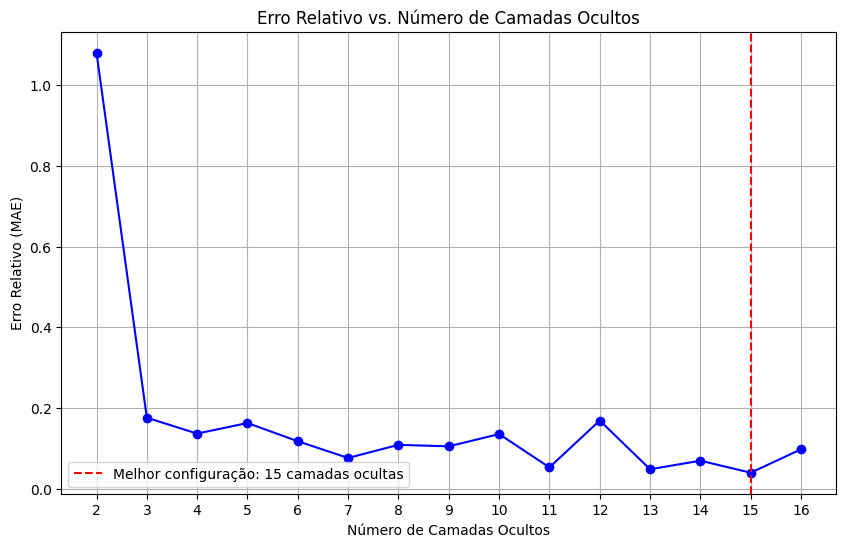

In [8]:
camadas, mae_errors = zip(*erros)
plt.figure(figsize=(10, 6))
plt.plot(camadas, mae_errors, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Camadas Ocultos')
plt.ylabel('Erro Relativo (MAE)')
plt.title('Erro Relativo vs. Número de Camadas Ocultos')
plt.grid(True)
plt.xticks(camadas)
plt.axvline(x=best_config[0], color='r', linestyle='--', label=f'Melhor configuração: {best_config[0]} camadas ocultas')
plt.legend()
plt.show()

Feito isso, o passo seguinte é variar o número de nós ocultas, fixando o número de camadas

In [9]:
erros_n = []
for i in range(10, 70, 5):
  otimizador = tf.keras.optimizers.Adam(learning_rate = 0.01)
  modelo = modelo_RNA(x_treino, 'linear', i, best_config[0])
  modelo = padronizar_peso(modelo)

  resultado, modelo = treino_modelo(modelo, otimizador, 'mse', ['mae'], x_treino, y_treino, x_val, y_val, 330)

  y_pred = modelo.predict(x_val)

  erro = mean_absolute_error(y_val, y_pred)
  erros_n.append((i, erro))

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 289/330
16/16 [==============================] - 0s 8ms/step - loss: 0.0415 - mae: 0.1603 - val_loss: 0.0652 - val_mae: 0.1604
Epoch 290/330
16/16 [==============================] - 0s 8ms/step - loss: 0.0548 - mae: 0.1895 - val_loss: 0.0579 - val_mae: 0.2090
Epoch 291/330
16/16 [==============================] - 0s 8ms/step - loss: 0.0961 - mae: 0.2450 - val_loss: 0.0181 - val_mae: 0.0871
Epoch 292/330
16/16 [==============================] - 0s 7ms/step - loss: 0.0596 - mae: 0.1702 - val_loss: 0.1365 - val_mae: 0.3067
Epoch 293/330
16/16 [==============================] - 0s 7ms/step - loss: 0.0467 - mae: 0.1665 - val_loss: 0.2079 - val_mae: 0.3238
Epoch 294/330
16/16 [==============================] - 0s 8ms/step - loss: 0.1700 - mae: 0.3363 - val_loss: 0.3414 - val_mae: 0.5526
Epoch 295/330
16/16 [==============================] - 0s 7ms/step - loss: 0.3523 - mae: 0.4859 - val_loss: 0.0844 - val_mae: 0.2478
Epoch 296/

In [10]:
best_config_n = min(erros_n, key=lambda x: x[1])

print(f'Melhor configuração: {best_config_n[0]} camadas ocultas com erro relativo de {best_config_n[1]:.4f}')

Melhor configuração: 10 camadas ocultas com erro relativo de 0.0503


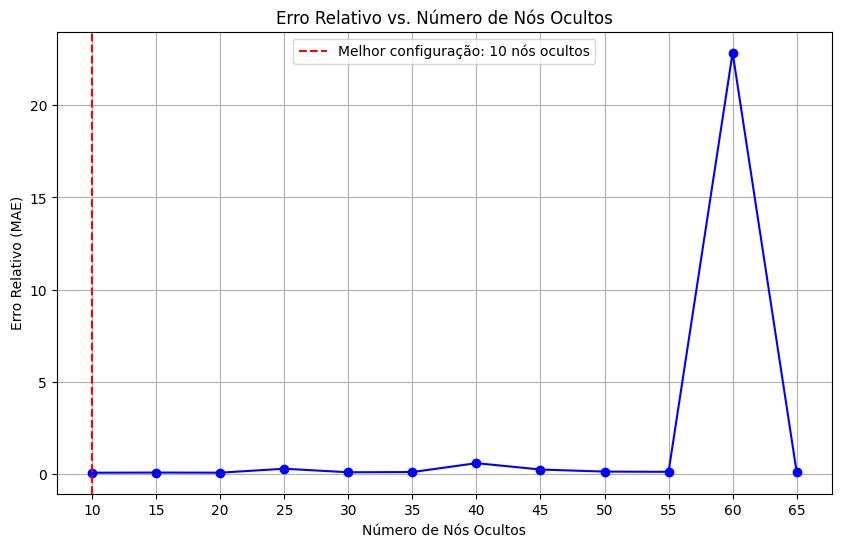

In [11]:
nos, mae_errors_n = zip(*erros_n)
plt.figure(figsize=(10, 6))
plt.plot(nos, mae_errors_n, marker='o', linestyle='-', color='b')
plt.xlabel('Número de Nós Ocultos')
plt.ylabel('Erro Relativo (MAE)')
plt.title('Erro Relativo vs. Número de Nós Ocultos')
plt.grid(True)
plt.xticks(nos)
plt.axvline(x=best_config_n[0], color='r', linestyle='--', label=f'Melhor configuração: {best_config_n[0]} nós ocultos')
plt.legend()
plt.show()

Por fim, deve-se analisar a rede em função da função de ativação e da taxa de aprendizado

In [12]:
resultados = list()
erros_relativos = list()
for i in funcoes:
  #modelo = modelo_RNA(x_treino, i, 40, 11)
  for j in taxas:
      otimizador = tf.keras.optimizers.Adam(learning_rate=j)
      modelo = modelo_RNA(x_treino, i, best_config_n[0], best_config[0])
      modelo = padronizar_peso(modelo)

      resultado, modelo = treino_modelo(modelo, 'adam', 'mse', ['mae'], x_treino, y_treino, x_val, y_val, 330)

      resultado = pd.DataFrame(resultado.history)
      resultados.append(resultado)

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 285/330
16/16 [==============================] - 0s 9ms/step - loss: 7.2042e-04 - mae: 0.0145 - val_loss: 0.0125 - val_mae: 0.0358
Epoch 286/330
16/16 [==============================] - 0s 9ms/step - loss: 7.3816e-04 - mae: 0.0137 - val_loss: 0.0137 - val_mae: 0.0407
Epoch 287/330
16/16 [==============================] - 0s 8ms/step - loss: 7.8772e-04 - mae: 0.0145 - val_loss: 0.0140 - val_mae: 0.0367
Epoch 288/330
16/16 [==============================] - 0s 8ms/step - loss: 9.3319e-04 - mae: 0.0139 - val_loss: 0.0125 - val_mae: 0.0396
Epoch 289/330
16/16 [==============================] - 0s 8ms/step - loss: 7.0230e-04 - mae: 0.0131 - val_loss: 0.0124 - val_mae: 0.0357
Epoch 290/330
16/16 [==============================] - 0s 10ms/step - loss: 7.1932e-04 - mae: 0.0133 - val_loss: 0.0124 - val_mae: 0.0356
Epoch 291/330
16/16 [==============================] - 0s 8ms/step - loss: 6.6864e-04 - mae: 0.0136 - val_loss: 0.0137

In [16]:
len(resultado_df)

330

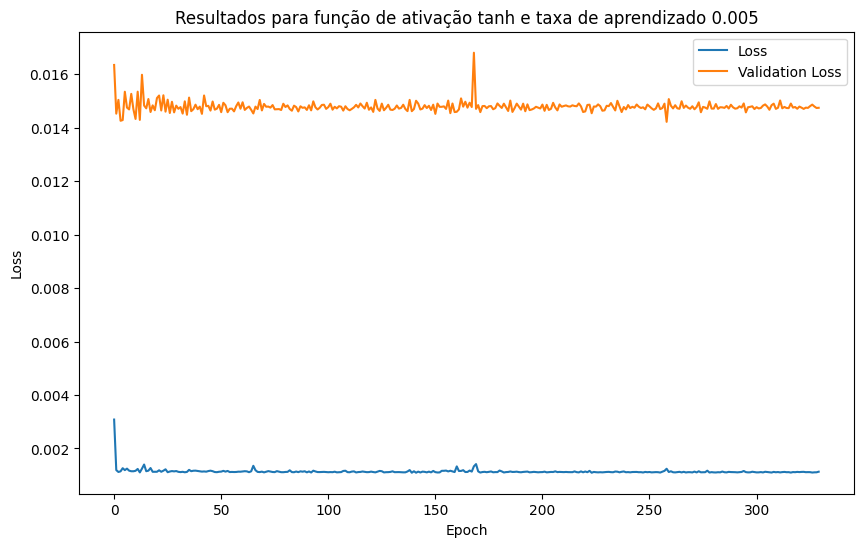

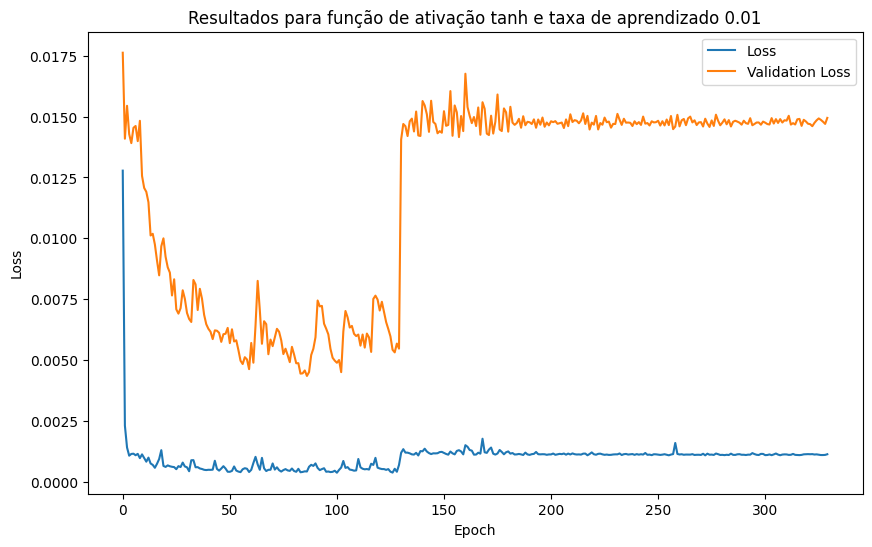

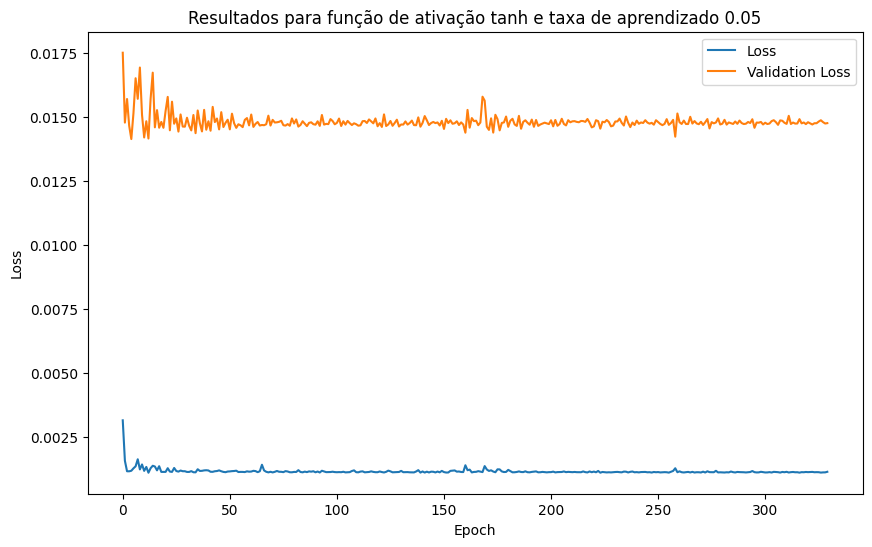

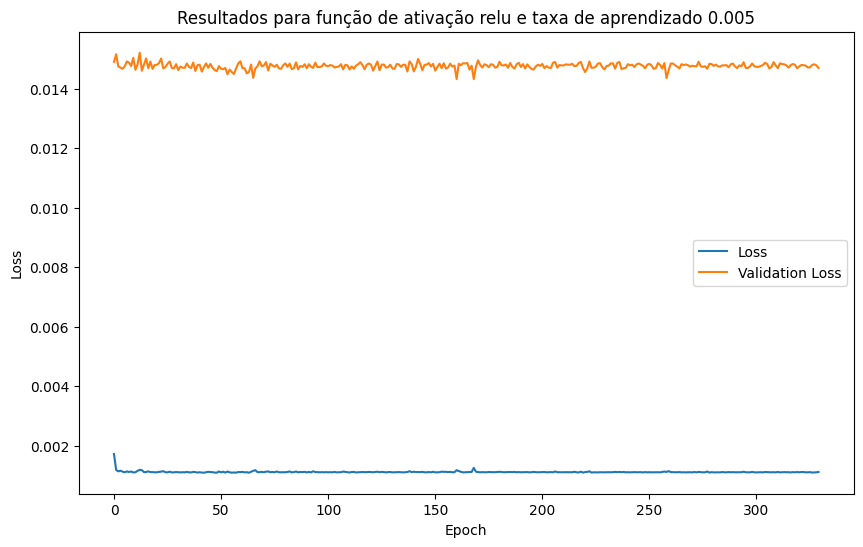

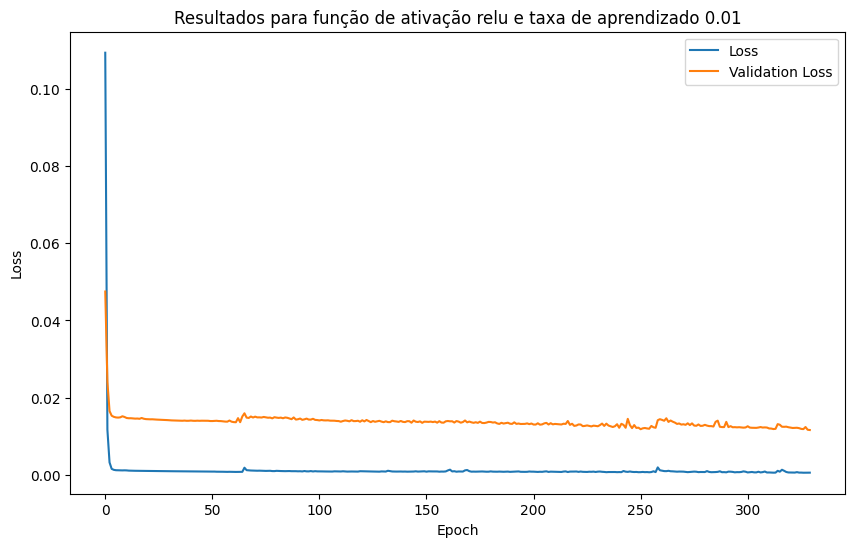

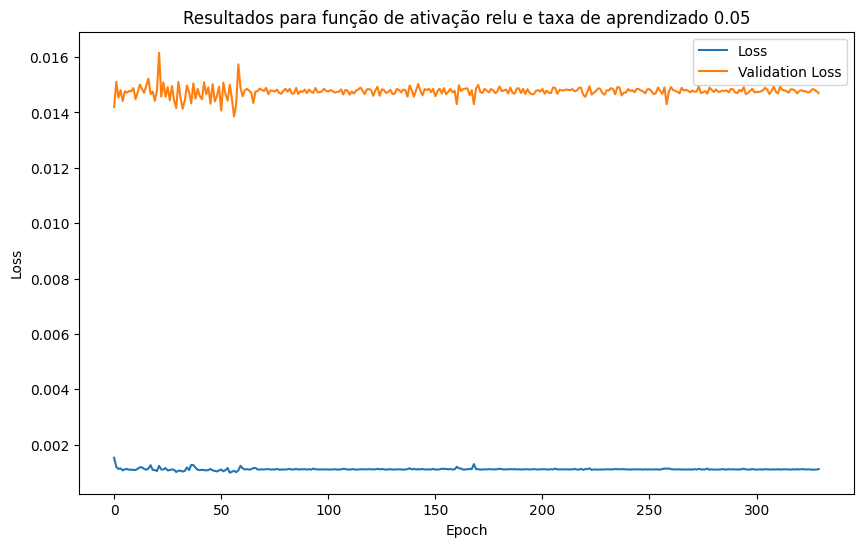

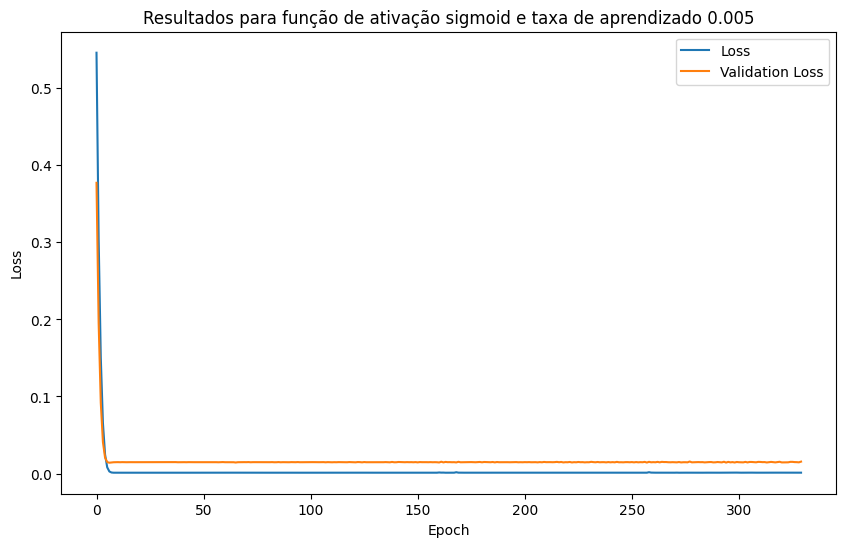

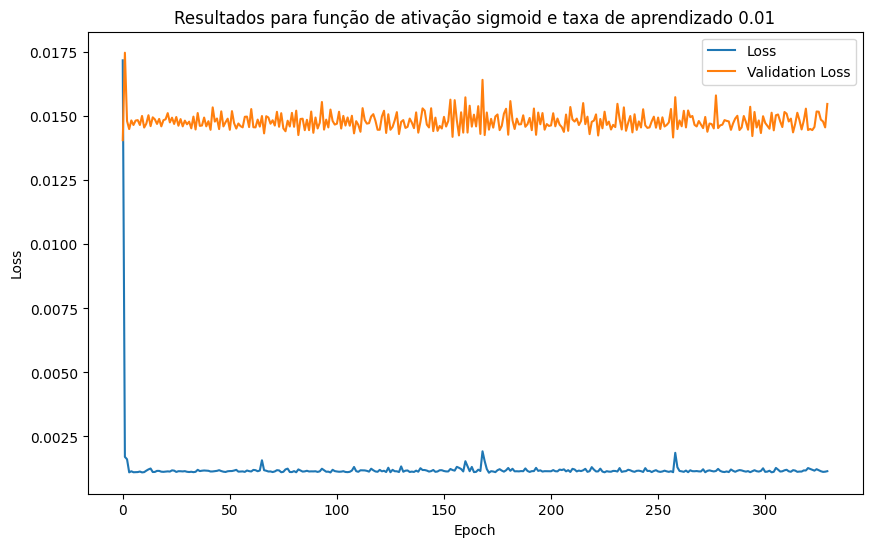

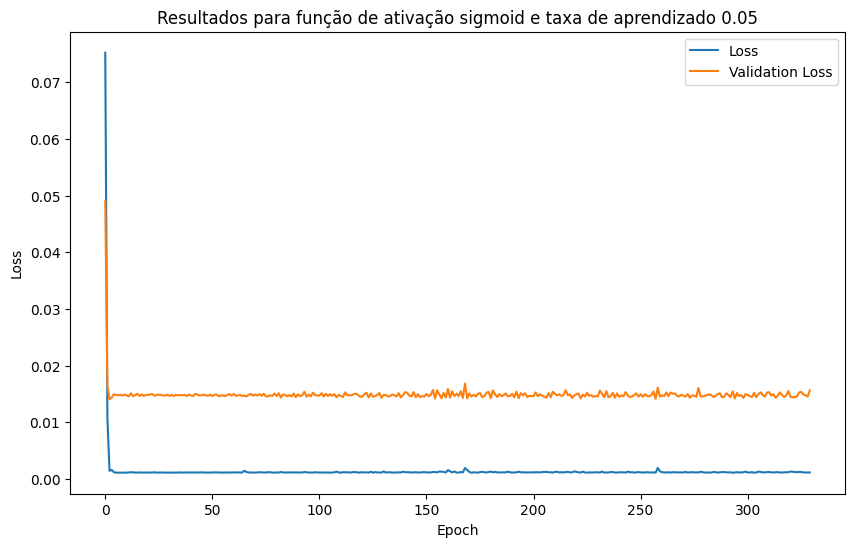

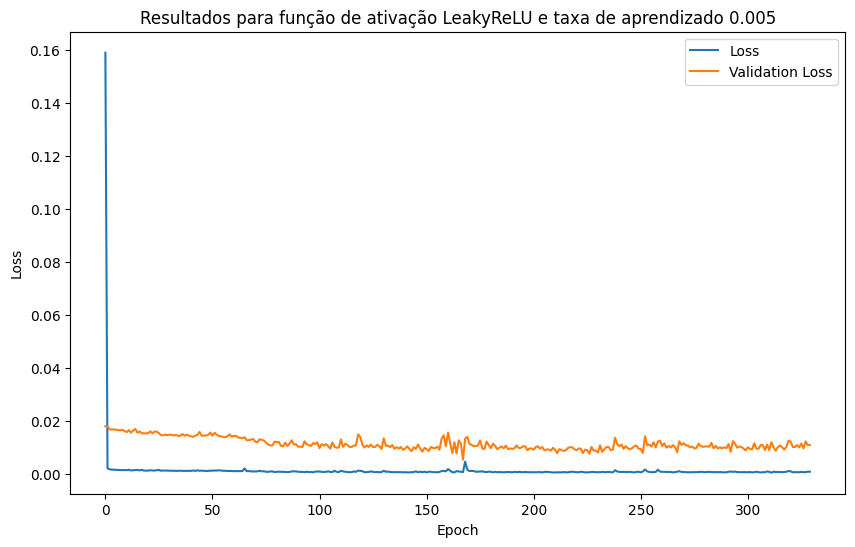

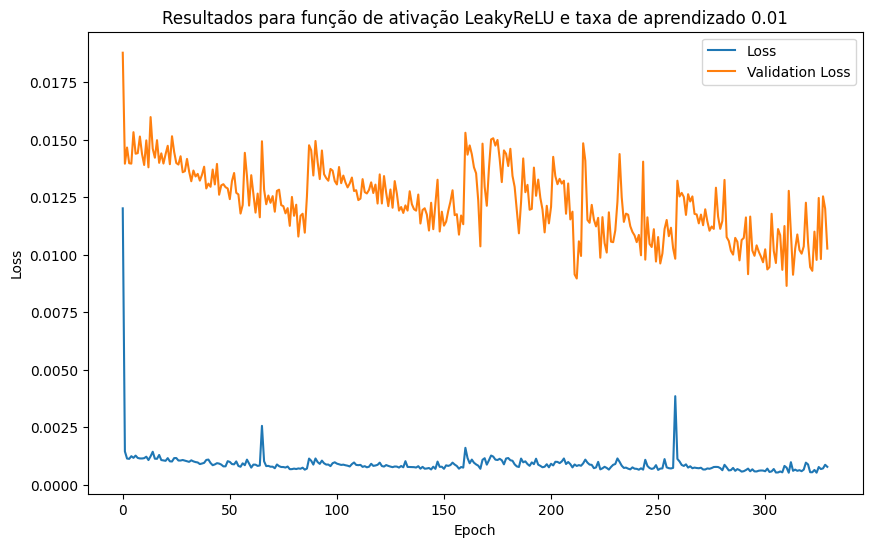

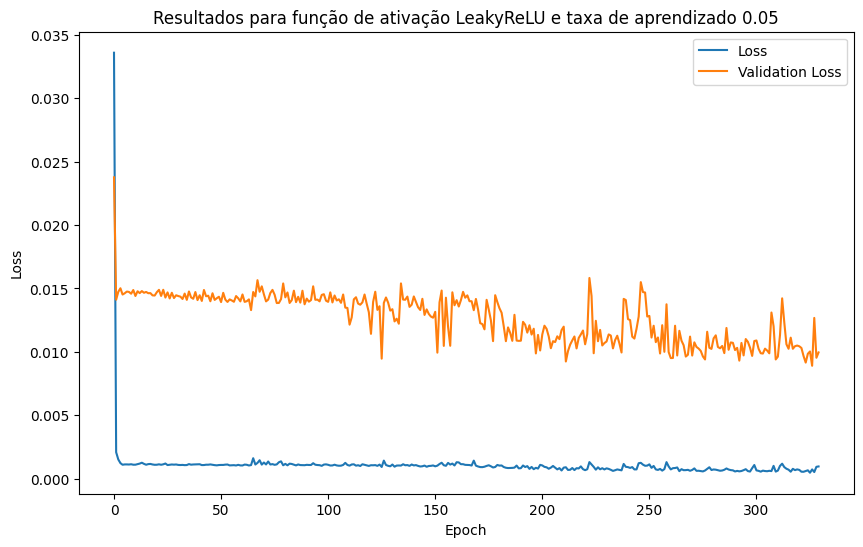

In [17]:
for i, funcao in enumerate(funcoes):
    for j, taxa in enumerate(taxas):
        resultado_df = resultados[i * len(taxas) + j]
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(resultado_df)), resultado_df['loss'], label='Loss')
        plt.plot(range(len(resultado_df)), resultado_df['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Resultados para função de ativação {funcao} e taxa de aprendizado {taxa}')
        plt.legend()
        plt.show()